# PROJET CARTOON : Pierre et Jame

In [61]:
from skimage import data, segmentation, color
from skimage import graph
from skimage import io
from matplotlib import pyplot as plt
from skimage import util

Image utilisé :

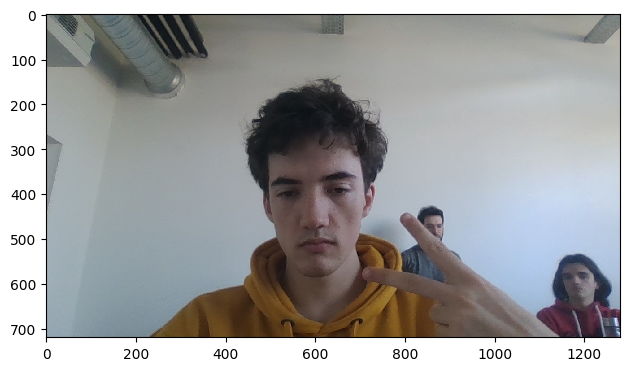

In [62]:
img = util.img_as_float(io.imread("resources/images/test_1.jpg"))
io.imshow(img)

# Premier test de postérization de la couleur de l'image

Utilisation de la segmentation pour donner un coté peinture à l'huile

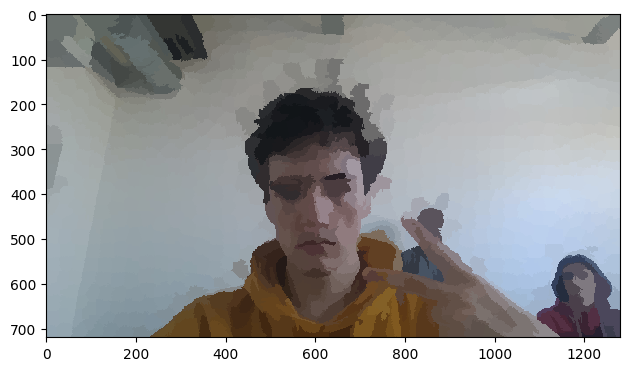

In [63]:
img_shape = img.shape

lenght_average = (img_shape[0] + img_shape[1])/2

labels1 = segmentation.slic(img, compactness=2, n_segments=lenght_average, start_label=1)
img_posterized = color.label2rgb(labels1, img, kind='avg', bg_label=0)



io.imshow(img_posterized)

# Tweeks concernant la couleur

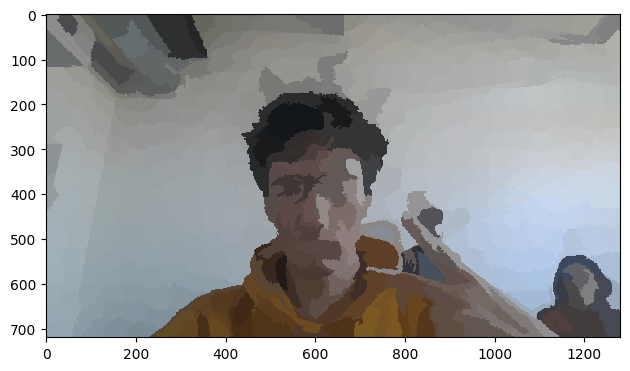

In [64]:
from skimage import filters

filtered_img = filters.median(img)

labels1 = segmentation.slic(img, compactness=2, n_segments=lenght_average/2, start_label=1)
posterized_image = color.label2rgb(labels1, filtered_img, kind='avg', bg_label=0)


io.imshow(posterized_image)

Option en utilisant un filtre de type posterize sur la luminosité avec un flou gaussien en teinte et saturation pour donner un effet acrylique.

C:\Users\pierr\AppData\Local\Temp\ipykernel_18496\1724874326.py:10: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  blured_img = filters.gaussian(img_denoised, sigma = lenght_average*0.01)
C:\Users\pierr\AppData\Local\Temp\ipykernel_18496\1724874326.py:33: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  img_hsv[:,:,2] = filters.gaussian(img_hsv**(1/gamma), sigma = lenght_average*0.0015)[:,:,2]


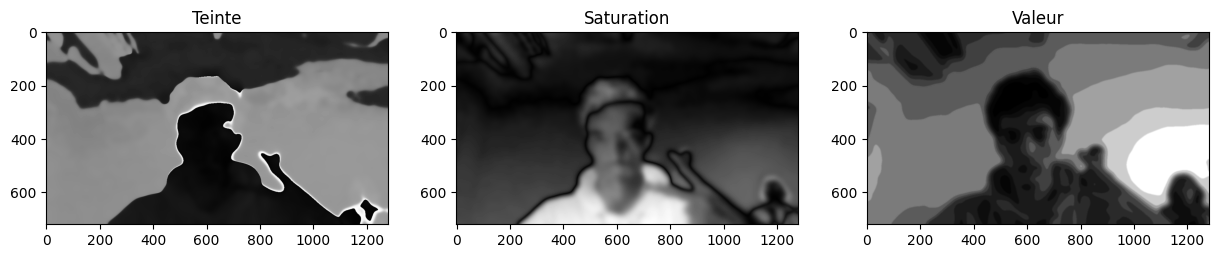

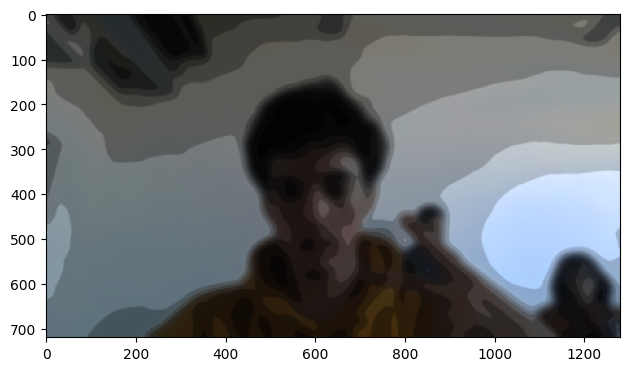

In [65]:
from skimage import util
from skimage import color
import numpy as np




img_denoised = filters.median(img)

blured_img = filters.gaussian(img_denoised, sigma = lenght_average*0.01)

img_hsv = color.rgb2hsv(blured_img)

blured_img = color.rgb2hsv(blured_img)



#img_hsv[:,:,2] = filters.gaussian(color.rgb2hsv(posterized_image)[:,:,2], sigma = 4)


def my_function(x):
    posterization_steps = 12
    return min(round((x+1/posterization_steps)*posterization_steps)/posterization_steps,1)

gamma = 0.4

img_hsv[:,:,1] = img_hsv[:,:,1]**0.8

#img_hsv[:,:,2] = filters.gaussian(img_denoised, sigma = lenght_average*0.004)[:,:,2]**gamma

img_hsv[:,:,2] = np.vectorize(my_function)(img_hsv[:,:,2])

img_hsv[:,:,2] = filters.gaussian(img_hsv**(1/gamma), sigma = lenght_average*0.0015)[:,:,2]
# img_hsv[:,:,2] = img_hsv[:,:,2]**(1/gamma)

fig = plt.figure(figsize=(15, 8))
for i, c in enumerate(["Teinte", "Saturation", "Valeur"]):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(img_hsv[:,:,i], cmap="gray")
    plt.title(c)
plt.show()

colors = color.hsv2rgb(img_hsv)
io.imshow(colors)

## Détection des contours : comparaison Prewitt, Sobel et Canny

Un contour est une région de l'image où le gradient est élevé, c'est à dire où l'intensité change brutalement.

Prewitt est un filtre inventé par le mathématicien britannique Brian Prewitt. Le filtre de Prewitt se compose de deux matrices de convolution, une pour détecter les contours verticaux et l'autre pour les contours horizontaux. Chaque matrice est de taille 3x3 et a des coefficients spécifiques pour effectuer la convolution. Pour cela `filters.prewitt` Nous fait les deux en même temps.

Sobel est un filtre proposé par Sobel et Feldman en 1968 qui permet de faire de la détection de contour. Comme pour le filtre de Prewitt, il est composé de deux kernels, l'un pour détecter les gradients horizontaux et l'autre pour détecter les gradien verticaux, `filters.sobel` nous permet de faire les deux en même temps.

Canny est un algorithme de détection de coutours qui réalise plusieurs opérations :
1. Réduction du bruit par un lissage gaussien
2. Calculs des normes et des angles des gradients
3. Suppression des gradients non maximaux
4. Seuillage par hystérésie

Pour cela, nous utilisons `feature.canny`.

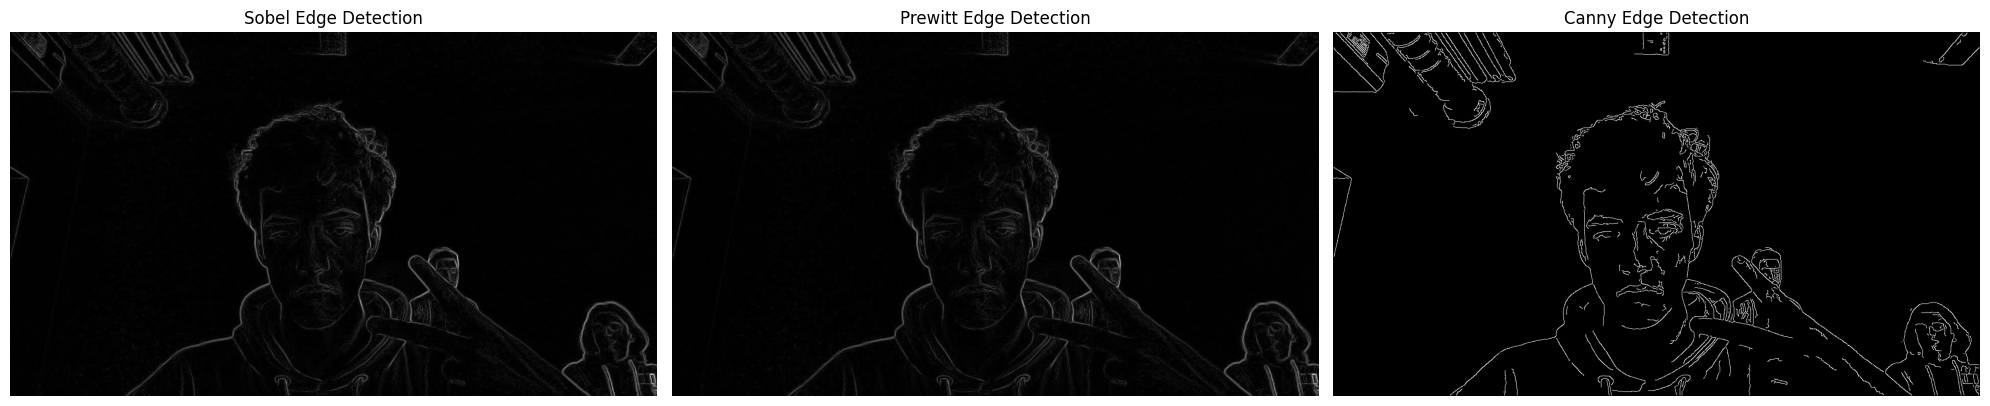

In [66]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import filters
from skimage.data import camera
from skimage.util import compare_images
from skimage.util import img_as_float
from skimage import io

from skimage import feature


edge_sobel = filters.sobel(img[:,:,1])
edge_prewitt = filters.prewitt(img[:,:,1])
edge_canny = feature.canny(img[:,:,1])


fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(20, 6))

axes[0].imshow(edge_sobel, cmap="gray")
axes[0].set_title('Sobel Edge Detection')

axes[1].imshow(edge_prewitt, cmap="gray")
axes[1].set_title('Prewitt Edge Detection')

axes[2].imshow(edge_canny, cmap="gray")
axes[2].set_title('Canny Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Method Otsu

Continuons avec le filtre de sobel :

La méthode Otsu consiste à chercher le seuil optimal, c'est-à-dire celui qui minimise la variance intra-classe au sein des pixels blancs et des pixels noirs. Etant donné que notre objectif est de séparer le mieux possible les coutours blancs du reste noir elle est la meilleur solution.

Deplus, nous avons la contraite de la vidéo, il faut donc prendre en compte les changements de luminosité et de couleur. Le seuil d'Otsu est calculé à chaque fois pour être le meilleur seuil, nous n'avons donc plus besoin d'adapter le seuil à chaque frame à la main.

Nous n'utilisons pas Sauvola car cette méthode est plutôt adapté au texte.

Text(0.5, 1.0, 'Sobel Edge Detection + Niblack')

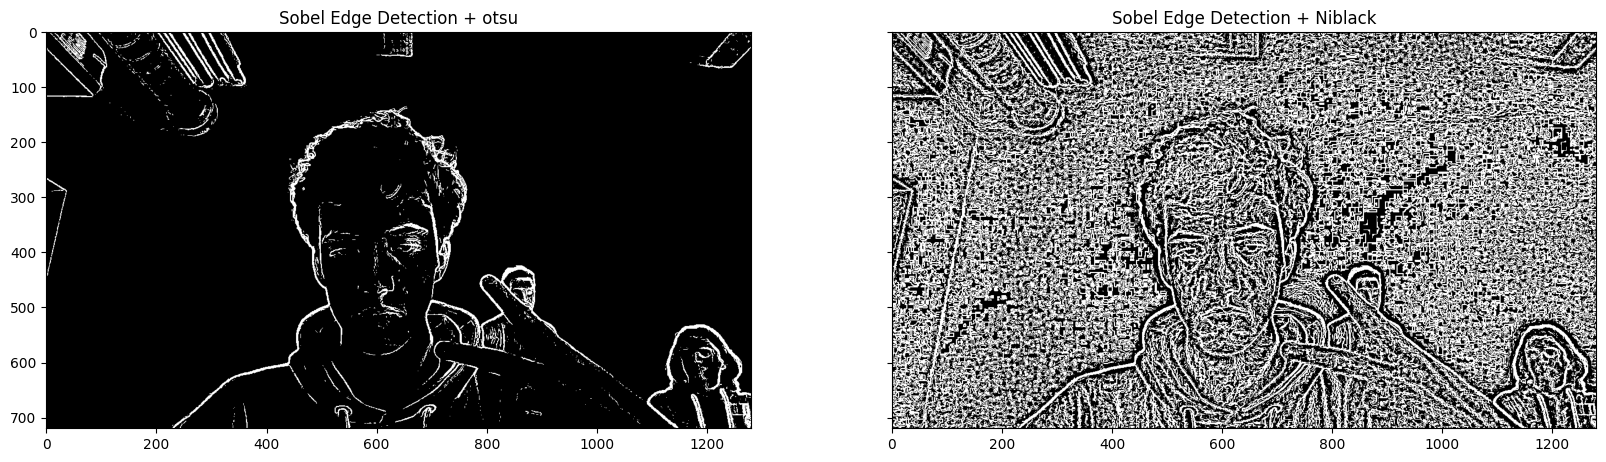

In [67]:
from skimage import filters

otsu_threshold = filters.threshold_otsu(edge_sobel)
otsu_image= edge_sobel > otsu_threshold

#image_binarized = edge_canny > otsu_threshold

niblack_threshold = filters.threshold_niblack(edge_sobel)
niblack_image= edge_sobel > niblack_threshold


fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20, 6))

axes[0].imshow(otsu_image, cmap="gray")
axes[0].set_title('Sobel Edge Detection + otsu')

axes[1].imshow(niblack_image, cmap="gray")
axes[1].set_title('Sobel Edge Detection + Niblack')


Le seuillage grâce à Ostu, nous donne le résultat que nous voulons.

## Ouverture morphologique

Pour diminuner les artéfactes qui ne font pas partis des contours, nous allons utiliser une ouverture morphologique.

Text(0.5, 1.0, 'Sobel Edge Detection + otsu + morphology opening')

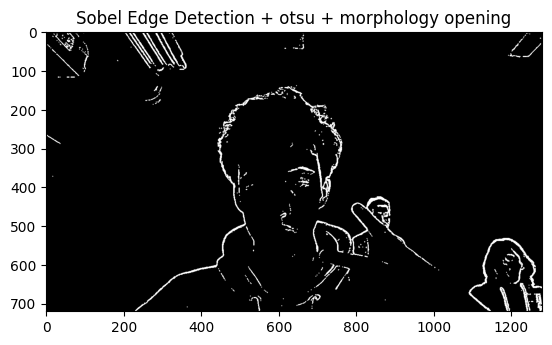

In [68]:
from skimage import morphology
from skimage import util

opening_image = morphology.opening(otsu_image)
plt.imshow(opening_image, cmap="gray")
plt.title("Sobel Edge Detection + otsu + morphology opening")

Ci-dessus notre premier test combinant la détection de contour avec Sobel, une binarization avec Otsu, une ouverture morphologique et une postérisation :

Text(0.5, 1.0, 'Sobel Edge Detection + otsu + morphology opening + color posterization')

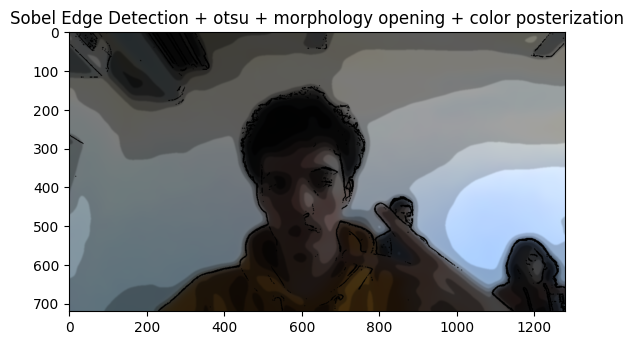

In [69]:
lines = util.invert(opening_image)

colors[:,:,0] *= lines
colors[:,:,1] *= lines
colors[:,:,2] *= lines
 
plt.imshow(colors, cmap="gray")
plt.title("Sobel Edge Detection + otsu + morphology opening + color posterization")

In [71]:
import cv2
import skimage
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from skimage.feature import Cascade
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np


def binarize_frame(frame):
    edge_sobel = filters.sobel(frame[:,:,1])
    edge_canny = feature.canny(frame[:,:,1])
    otsu_threshold = filters.threshold_otsu(edge_sobel)
    return edge_sobel > otsu_threshold

def posterize_values(value, steps = 12):
    return min(round((value)*steps)/steps,1)

def recolorize_frame(frame):
    
    frame_shape = frame.shape
    
    # Stylisitc choice
     #lenght_average = (img_shape[0] + img_shape[1])/2
     #blured_frame = filters.gaussian(frame, sigma = 2)
    blured_frame = frame
    
    # Convert to hsl
    frame_hsv = color.rgb2hsv(blured_frame)
    
    frame_hsv[:,:,0] = np.vectorize(posterize_values)(frame_hsv[:,:,0])


    # Boost Saturation
    frame_hsv[:,:,1] = frame_hsv[:,:,1]**0.8

    gamma = 0.8

    frame_hsv[:,:,2] = frame_hsv[:,:,2]**gamma
    
    frame_hsv[:,:,2] = np.vectorize(posterize_values)(frame_hsv[:,:,2])**(1/gamma)

    #frame_hsv[:,:,2] = filters.gaussian(frame_hsv**(1/gamma), sigma = lenght_average*0.0015)[:,:,2]

    return color.hsv2rgb(frame_hsv)

# define a video capture object
vid = cv2.VideoCapture(0)

while (True):

    # Capture the video frame
    # by frame
    ret, frame = vid.read()

    frame = np.flip(frame, axis=1)

    image_binarized = binarize_frame(frame)

    lines = util.invert(image_binarized)

    frame = recolorize_frame(frame)

    # Add lines
    frame[:,:,0] *= lines
    frame[:,:,1] *= lines
    frame[:,:,2] *= lines

    # Display the resulting frame
    cv2.imshow('frame', frame)

    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

AxisError: axis 1 is out of bounds for array of dimension 0

Pour conclure, 